In [1]:
from datasets import load_dataset
import pandas as pd

In [2]:
lang = "py"
run_lang = "python"

In [192]:
import wandb

api = wandb.Api()
entity, project = "loubnabnl", "scaling_laws"  # set to your entity and project 
runs = api.runs(entity + "/" + project) 

summary_list, config_list, name_list = [], [], []
for run in runs: 
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files 
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        {k: v for k,v in run.config.items()
         if not k.startswith('_')})

    # .name is the human-readable name of the run.
    name_list.append(run.name)

orig_runs_df = pd.DataFrame({
    "summary": summary_list,
    "config": config_list,
    "name": name_list
    })

def expand_dict_to_columns(df, col):
    return pd.concat([df.drop([col], axis=1),  pd.json_normalize(df[col])], axis=1)

run_df = expand_dict_to_columns(orig_runs_df, "summary")
run_df = expand_dict_to_columns(run_df, "config")

keep_cols = [c for c in run_df if "lm-loss-validation/TEST_" not in c]
run_df = run_df[keep_cols]

df_run = run_df[run_df["_step"] >= .99 * run_df["train_iters"]]
df_run.head(2)

,name,_timestamp,loss-scale,learning-rate,_step,lm loss,samples,_runtime,grad-norm,lm loss validation,...,train_weighted_split_paths,valid_weighted_split_names,valid_weighted_split_paths,train_weighted_split_splits,valid_weighted_split_splits,train_weighted_split_weights,valid_weighted_split_weights,test_weighted_split_paths_path,train_weighted_split_paths_path,valid_weighted_split_paths_path
11,run_7302.6M_6e+19_bs1_idx_69-pp2-8,1.679240e+09,1.0,4.467839e-09,1305.0,1.779671,665600.0,10447.029247,0.22727,NaN,...,[[/fsx/loubna/data/stack_new/code/css/gpt2-pre...,"[VALID_css, VALID_prolog, VALID_c, VALID_fortr...",[[/fsx/loubna/data/stack_new/code/css/gpt2-pre...,"[[0:0.969, 0:0.969, 0:0.969, 0:0.969, 0:0.969,...","[[0.969:0.999], [0.969:0.999], [0.969:0.999], ...","[[3.0, 0.01, 53.89, 1.78, 0.85, 5.68, 0.01, 1....","[[1], [1], [1], [1], [1], [1], [1], [1], [1], ...",NaN,NaN,NaN
12,run_7302.6M_3e+20_bs1_idx_96-pp2-16,1.679259e+09,1.0,5.786455e-10,6529.0,1.241626,3338240.0,29714.369224,0.140716,NaN,...,[[/fsx/loubna/data/stack_new/code/css/gpt2-pre...,"[VALID_css, VALID_prolog, VALID_c, VALID_fortr...",[[/fsx/loubna/data/stack_new/code/css/gpt2-pre...,"[[0:0.969, 0:0.969, 0:0.969, 0:0.969, 0:0.969,...","[[0.969:0.999], [0.969:0.999], [0.969:0.999], ...","[[3.0, 0.01, 53.89, 1.78, 0.85, 5.68, 0.01, 1....","[[1], [1], [1], [1], [1], [1], [1], [1], [1], ...",NaN,NaN,NaN


In [193]:
scores = load_dataset("nuprl/pass_k_with_MultiPL-E", split="train", use_auth_token=True, revision="bigcode_scaling_laws")

scores = scores.map(lambda x: {"idx": int(x["Experiment"].split("idx_")[1].split("-")[0])})
scores = scores.map(lambda x: {"lang": x["Experiment"].split("humaneval-")[1].split("-")[0]})

scores = scores.filter(lambda x: x["k"]==100)
scores = scores.filter(lambda x: x["lang"]==lang)

df_scores = scores.to_pandas()

Using custom data configuration nuprl--pass_k_with_MultiPL-E-c92221ca283a18dd
Found cached dataset parquet (/Users/harm.devries/.cache/huggingface/datasets/nuprl___parquet/nuprl--pass_k_with_MultiPL-E-c92221ca283a18dd/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Loading cached processed dataset at /Users/harm.devries/.cache/huggingface/datasets/nuprl___parquet/nuprl--pass_k_with_MultiPL-E-c92221ca283a18dd/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-6a54d5e1c55fe093.arrow
Loading cached processed dataset at /Users/harm.devries/.cache/huggingface/datasets/nuprl___parquet/nuprl--pass_k_with_MultiPL-E-c92221ca283a18dd/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-19425d89520c9fdd.arrow
Loading cached processed dataset at /Users/harm.devries/.cache/huggingface/datasets/nuprl___parquet/nuprl--pass_k_with_MultiPL-E-c92221ca283a18dd/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/c

In [194]:
df_scores

,Experiment,k,PassRate,idx,lang
0,humaneval-py-bigcode_scalinglaws_run_1124.9M_1...,100,0.158044,79,py
1,humaneval-py-bigcode_scalinglaws_run_1124.9M_6...,100,0.131404,64,py
2,humaneval-py-bigcode_scalinglaws_run_15.9M_3e+...,100,0.010788,39,py
3,humaneval-py-bigcode_scalinglaws_run_111.5M_1e...,100,0.050874,30,py
4,humaneval-py-bigcode_scalinglaws_run_3026.4M_6...,100,0.065264,67,py
...,...,...,...,...,...
92,humaneval-py-bigcode_scalinglaws_run_6.9M_6e+1...,100,0.000000,11,py
93,humaneval-py-bigcode_scalinglaws_run_286.4M_3e...,100,0.208808,87,py
94,humaneval-py-bigcode_scalinglaws_run_286.4M_1e...,100,0.168398,75,py
95,humaneval-py-bigcode_scalinglaws_run_6.9M_3e+1...,100,0.000000,0,py


In [195]:
df_experiments = pd.read_csv("scaling_laws.csv")

In [196]:
df = df_scores.merge(df_experiments, how="left", on="idx")

In [197]:
df.sort_values(by="PassRate", ascending=False).head(3)

,Experiment,k,PassRate,idx,lang,num_layer,hidden_size,num_heads,param_count,compute,...,attention_head_type,sequence_length,batch_size_tokens,global_batch_size,learning_rate,num_gpu,training_time,micro_batch_size,training_iters,lr_warmup_iters
26,humaneval-py-bigcode_scalinglaws_run_1124.9M_1...,100,0.315121,110,py,24,2048,16,1124.9,1.000000e+21,...,multiquery,2048,524000.0,256,0.00020,32,2.898,8,282599,1000
69,humaneval-py-bigcode_scalinglaws_run_874.2M_1e...,100,0.312185,109,py,24,1792,14,874.2,1.000000e+21,...,multiquery,2048,524000.0,256,0.00020,32,2.898,8,363648,1000
20,humaneval-py-bigcode_scalinglaws_run_2118.0M_1...,100,0.304948,112,py,30,2560,20,2118.0,1.000000e+21,...,multiquery,2048,524000.0,256,0.00015,32,2.898,8,150090,1000


In [198]:
df["name"] = df["Experiment"].apply(lambda x: x.split("bigcode_scalinglaws_")[1].split("-0.8")[0])

df.head()

,Experiment,k,PassRate,idx,lang,num_layer,hidden_size,num_heads,param_count,compute,...,sequence_length,batch_size_tokens,global_batch_size,learning_rate,num_gpu,training_time,micro_batch_size,training_iters,lr_warmup_iters,name
0,humaneval-py-bigcode_scalinglaws_run_1124.9M_1...,100,0.158044,79,py,24,2048,16,1124.9,1.000000e+20,...,2048,524000.0,256,0.00020,8,1.159,32,28259,1000,run_1124.9M_1e+20_bs8_idx_79
1,humaneval-py-bigcode_scalinglaws_run_1124.9M_6...,100,0.131404,64,py,24,2048,16,1124.9,6.000000e+19,...,2048,524000.0,256,0.00020,8,0.696,32,16955,1000,run_1124.9M_6e+19_bs8_idx_64
2,humaneval-py-bigcode_scalinglaws_run_15.9M_3e+...,100,0.010788,39,py,4,256,4,15.9,3.000000e+19,...,2048,524000.0,256,0.00030,8,0.348,32,599634,1000,run_15.9M_3e+19_bs32_idx_39
3,humaneval-py-bigcode_scalinglaws_run_111.5M_1e...,100,0.050874,30,py,12,768,12,111.5,1.000000e+19,...,2048,524000.0,256,0.00030,2,0.464,128,28515,1000,run_111.5M_1e+19_bs32_idx_30
4,humaneval-py-bigcode_scalinglaws_run_3026.4M_6...,100,0.065264,67,py,36,2816,22,3026.4,6.000000e+19,...,2048,524000.0,256,0.00015,8,0.696,32,6302,630,run_3026.4M_6e+19_bs2_idx_67


In [199]:
df = df.merge(df_run[["name", f"lm-loss-validation/VALID_{run_lang}/lm loss validation"]], left_on="name", right_on="name")
df = df.rename(columns={f"lm-loss-validation/VALID_{run_lang}/lm loss validation": "valid_loss"})
df.head()

,Experiment,k,PassRate,idx,lang,num_layer,hidden_size,num_heads,param_count,compute,...,batch_size_tokens,global_batch_size,learning_rate,num_gpu,training_time,micro_batch_size,training_iters,lr_warmup_iters,name,valid_loss
0,humaneval-py-bigcode_scalinglaws_run_1124.9M_1...,100,0.158044,79,py,24,2048,16,1124.9,1.000000e+20,...,524000.0,256,0.00020,8,1.159,32,28259,1000,run_1124.9M_1e+20_bs8_idx_79,1.158141
1,humaneval-py-bigcode_scalinglaws_run_1124.9M_6...,100,0.131404,64,py,24,2048,16,1124.9,6.000000e+19,...,524000.0,256,0.00020,8,0.696,32,16955,1000,run_1124.9M_6e+19_bs8_idx_64,1.213946
2,humaneval-py-bigcode_scalinglaws_run_15.9M_3e+...,100,0.010788,39,py,4,256,4,15.9,3.000000e+19,...,524000.0,256,0.00030,8,0.348,32,599634,1000,run_15.9M_3e+19_bs32_idx_39,1.904096
3,humaneval-py-bigcode_scalinglaws_run_111.5M_1e...,100,0.050874,30,py,12,768,12,111.5,1.000000e+19,...,524000.0,256,0.00030,2,0.464,128,28515,1000,run_111.5M_1e+19_bs32_idx_30,1.389879
4,humaneval-py-bigcode_scalinglaws_run_3026.4M_6...,100,0.065264,67,py,36,2816,22,3026.4,6.000000e+19,...,524000.0,256,0.00015,8,0.696,32,6302,630,run_3026.4M_6e+19_bs2_idx_67,1.359987


In [200]:
import torch
import numpy as np

def loss(inp, params):
    a, b, e, alpha, beta = params[0], params[1], params[2], params[3], params[4]
    pre_lse = torch.stack([a - alpha*torch.log(inp[:, 0]), b - beta*torch.log(inp[:, 1]), e.expand((inp.shape[0]))])
    post_lse = torch.logsumexp(pre_lse, dim=0)
    huber_loss = torch.nn.functional.huber_loss(post_lse, torch.log(inp[:, 2]), delta=1e-3, reduction='none')
    return huber_loss.sum()

def minimize_loss(inp, init_params=[6, 6, -1, 0.28, 0.32], steps=50):
    params = torch.nn.Parameter(data=torch.Tensor(init_params))
    
    lbfgs = torch.optim.LBFGS([params],
                    lr=1e-1,
                    history_size=10, 
                    max_iter=20, 
                    line_search_fn="strong_wolfe")

    def closure():
        lbfgs.zero_grad()
        l = loss(inp, params)
        l.backward()
        return l

    history_lbfgs = []
    for i in range(steps):
        l = lbfgs.step(closure)
    return l, params

In [207]:
df_c = df[df['param_count'] > 50]
# df_c = df_c[df_c['compute'] >= 3e+19]
inp = torch.Tensor([[N*1e6, D, L] for N, D, L in 
                    zip(df_c["param_count"], df_c["training_tokens"], df_c["valid_loss"])])
inp.require_grad = True

min_loss = 1e10
for a in tqdm(np.linspace(0, 12, 4)):
    for b in np.linspace(0, 12, 4):
        for e in np.linspace(-1, 1, 4):
            for alpha in np.linspace(0, 1, 4):
                for beta in np.linspace(0, 1, 4):
                    l, params = minimize_loss(inp, [a, b, e, alpha, beta])
                    if l < min_loss:
                        min_loss = l
                        best_params = params.detach().numpy()

print(min_loss)
print(best_params)

100%|█████████████████████████████████████████████| 4/4 [02:31<00:00, 37.93s/it]

tensor(0.0007, grad_fn=<SumBackward0>)
[10.144976   10.020467   -0.15036352  0.6096702   0.49244583]


In [208]:
opt_alpha = best_params[-2]
opt_beta = best_params[-1]

opt_a =  opt_beta / (opt_alpha+opt_beta)
opt_b =  opt_alpha / (opt_alpha+opt_beta)

A = np.exp(best_params[0])
B = np.exp(best_params[1])
G = ((opt_alpha*A)/(opt_beta*B))**(1/(opt_alpha+opt_beta))

print("a", opt_a)
print("b", opt_b)
print("G", G)

a 0.44681847
b 0.55318147
G 1.3589624065171104


In [209]:
def opt_N_D(C):
    opt_N = G*(C/6)**opt_a
    opt_D = (1/G)*(C/6)**opt_b
    return opt_N, opt_D

In [222]:
scaling = []

for C in [1.92e19, 1.21e20, 1.23e22, 5.76e23, 3.85e24, 9.90e24, 3.43e25, 1.27e26, 1.30e28]:
    N, D = opt_N_D(C)
    scaling.append(
        {"compute": f"{C:e}",
         "parameters (B)": f"{N/1e9:.2f}",
         "tokens (B)": f"{D/1e9:.2f}",
        }
    )
     
pd.DataFrame(scaling)

,compute,parameters (B),tokens (B)
0,1.920000e+19,0.25,12.69
1,1.210000e+20,0.57,35.14
2,1.230000e+22,4.53,452.96
3,5.760000e+23,25.24,3803.29
4,3.850000e+24,58.99,10878.15
5,9.900000e+24,89.96,18342.39
6,3.430000e+25,156.73,36474.15
7,1.270000e+26,281.30,75244.40
8,1.300000e+28,2225.07,973747.15


In [180]:
def scaling_law(N, D, params):
    a, b, e, alpha, beta = params
    A = np.exp(a)
    B = np.exp(b)
    E = np.exp(e)
    
    L =  E + (A / (N**alpha)) + (B /(D**beta))
    
    return L

In [211]:
scaling_law(1e10, 100e9, best_params)

0.9668605288501972

In [221]:
import plotly.express as px
import plotly.graph_objects as go

color_map={
           "3e+18": "orange",
           "6e+18": "black",
           "3e+18": "brown",
           "1e+19": "green",
           "3e+19": "purple",
           "6e+19": "red",
           "1e+20": "blue",
           "3e+20": "pink",
           "6e+20": "gold",
           "1e+21": "silver",
          }

df_c['compute'] = df_c['compute'].astype(str)
fig = px.scatter(df_c, x='param_count', y='valid_loss', color='compute', 
                 log_x=True, color_discrete_map=color_map)

for compute in color_map.keys():
    tmp_df = df_c[df_c['compute'] == compute]
    df_d = list() 
    for _, row in tmp_df.iterrows():
        pred = scaling_law(row['param_count']*1e6, row['training_tokens'], best_params)
        df_d.append({'prediction': pred, 'param_count': row['param_count'], 'training_tokens': row['training_tokens']})
    fig2 = px.line(pd.DataFrame(df_d).sort_values('param_count'), 
                   x='param_count', y='prediction', log_x=True)
    fig2.update_traces(line_color=color_map[compute], line_width=2)
    fig = go.Figure(data=fig.data + fig2.data)

fig.show()

/var/folders/s8/cwrpf2_518x38_5_9_lzmw2r0000gp/T/ipykernel_9611/2928962758.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Inverse Pass Rate

In [467]:
df = df[df["PassRate"]>0.0]

In [468]:
def function(x):
    a, b, e, alpha, beta = x
    overall_sum = 0
    for N, D, L in zip(df["training_tokens"], df["param_count"], df["PassRate"]):
        L = 1/L
        element = huber(0.001, logsumexp([a - alpha*np.log(N),b -  beta*np.log(D), e]) - np.log(L))
        overall_sum+=element
    return overall_sum

In [469]:
min_value = 1e10

from tqdm import tqdm

for a in tqdm(np.linspace(0, 25, 6)):
    for b in np.linspace(0, 25, 6):
        for e in np.linspace(-1, 1, 5):
            for alpha in np.linspace(0, 2,5):
                for beta in np.linspace(0,2,5):
                    value = function((a, b, e, alpha, beta))
                    if value<min_value:
                        best_config = (a, b, e, alpha, beta)
                        min_value = value
best_config

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:08<00:00,  1.45s/it]


(25.0, 10.0, 0.5, 1.0, 1.5)

In [470]:
params = minimize(function, best_config, method="L-BFGS-B")
params

      fun: 0.01583050510669054
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 4.34027778e-07,  6.93889333e-07, -3.14678837e-07, -9.97361910e-06,
       -2.41091870e-06])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 954
      nit: 93
     njev: 159
   status: 0
  success: True
        x: array([19.98268472,  9.17922333,  0.75080129,  0.78776087,  1.46806481])

In [471]:
def scaling_law(N, D, params):
    a, b, e, alpha, beta = params
    A = np.exp(a)
    B = np.exp(b)
    E = np.exp(e)
    L =  E + (A / (N**alpha)) + (B /(D**beta))
    
    return 1/L

In [473]:
scaling_law(1e12, 10_000, params.x)

0.4348434064946986

Text(0, 0.5, 'Pass@100')

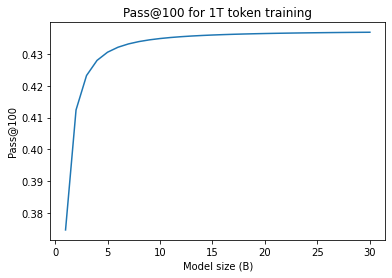

In [474]:
import matplotlib.pyplot as plt

x = np.linspace(1, 30, 30)

plt.plot(x, [scaling_law(1e12, i*1000, params.x) for i in x])
plt.title("Pass@100 for 1T token training")
plt.xlabel("Model size (B)")
plt.ylabel("Pass@100")

/var/folders/l4/2905jygx4tx5jv8_kn03vxsw0000gn/T/ipykernel_67683/1369441161.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  L =  E + (A / (N**alpha)) + (B /(D**beta))


Text(0, 0.5, 'Pass@100')

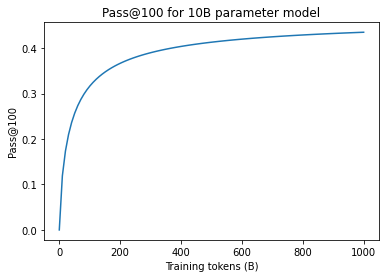

In [475]:
x = np.linspace(0, 1000, 100)

plt.plot(x, [scaling_law(i*1e9, 10_000, params.x) for i in x])
plt.title("Pass@100 for 10B parameter model")
plt.xlabel("Training tokens (B)")
plt.ylabel("Pass@100")

In [329]:
pass_rate = np.zeros((100, 100))
sizes = np.linspace(1, 15, 100)
tokens = np.linspace(1, 1000, 100)

for i, s in tqdm(enumerate(sizes)):
    for j, t in enumerate(tokens):
        pass_rate[i, j] = scaling_law(t*1e9, s*1_000, params.x)


100it [00:00, 1591.24it/s]


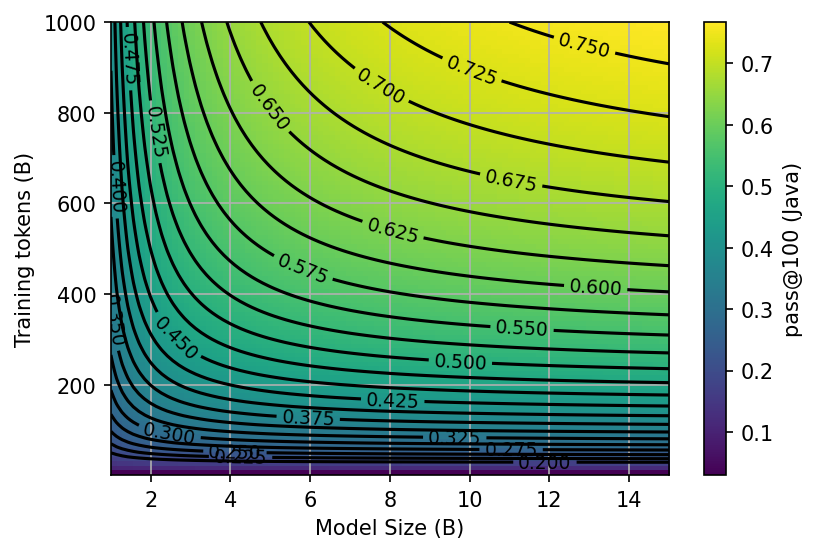

In [330]:
plt.figure(figsize=(6, 4), dpi=150)

plt.imshow(pass_rate.T, aspect="auto", extent=[1,15,1,1000], origin="lower")
plt.colorbar(label="pass@100 (Java)")

X, Y = np.meshgrid(sizes, tokens)
CS = plt.contour(X, Y, pass_rate.T, colors='k', levels=np.linspace(0.2, 0.9, 29))
plt.clabel(CS, fontsize=9, inline=1)

plt.xlabel("Model Size (B)")
plt.ylabel("Training tokens (B)")
plt.grid(visible=True)

In [265]:
sizes

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
        34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
        56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
        78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
        89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.,
       100.])